In [ ]:
from math import sqrt
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.seasonal import seasonal_decompose

from multiprocessing import cpu_count
from distributed import client
#from joblib import Parallel
#from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from load_data import load_data

register_matplotlib_converters()

plt.rc('figure',figsize=(16,12))

## Variables

Variables available:

    - air temp
    - ice concentration
    - ice thickness
    - salinity
    - ocean temp
    
    
Data for ocean is only available from 2019 to roughly present.

In [2]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [3]:
pabrc = load_data_local('station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')
weekly = pabrc.resample('W').mean()

<AxesSubplot:>

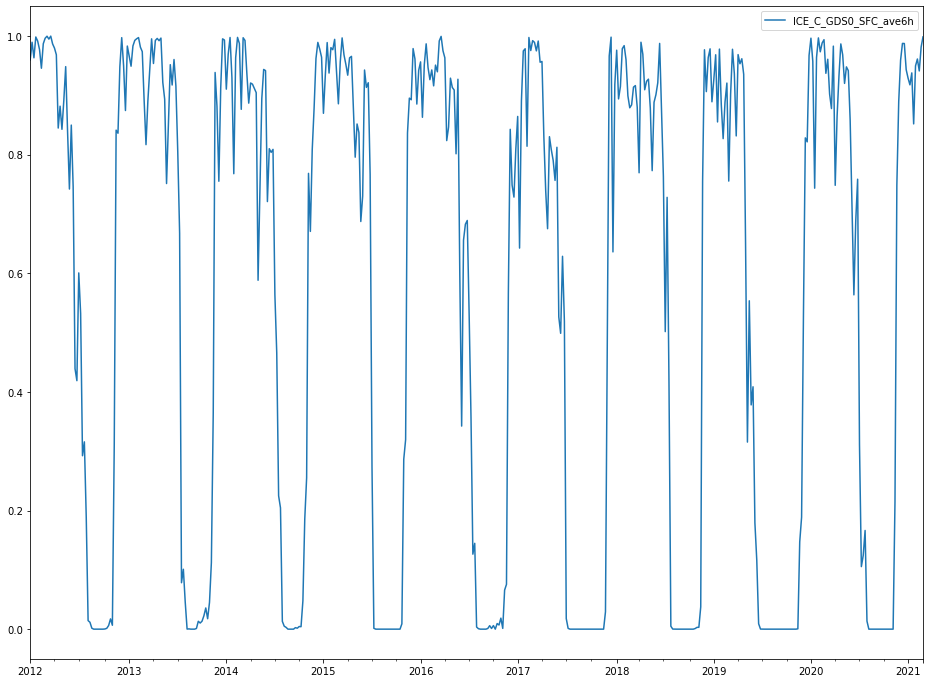

In [4]:
weekly.plot()

In [5]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [6]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [9]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                ilterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [10]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [11]:
 # create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [12]:
n_test = 62
# model configs
cfg_list = sarima_configs(seasonal=[4,12,26,52])
# grid search
scores = grid_search(weekly.values[:, 0], cfg_list, n_test, parallel=False)
for cfg, error in scores[:3]:
    print(cfg, error)


In [29]:
scores = [score_model(weekly.values[:, 0], n_test, cfg, debug=True) for cfg in cfg_list]

 > Model[[(0, 0, 0), (0, 0, 0, 4), 'n']] 0.754
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 0.754
 > Model[[(0, 0, 0), (0, 0, 0, 26), 'n']] 0.754
 > Model[[(0, 0, 0), (0, 0, 0, 52), 'n']] 0.754
 > Model[[(0, 0, 0), (0, 0, 1, 4), 'n']] 0.467


/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 0.608
 > Model[[(0, 0, 0), (0, 0, 1, 26), 'n']] 0.747
 > Model[[(0, 0, 0), (0, 0, 1, 52), 'n']] 0.604


/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 > Model[[(0, 0, 0), (0, 0, 2, 4), 'n']] 0.373
 > Model[[(0, 0, 0), (0, 0, 2, 12), 'n']] 0.578
 > Model[[(0, 0, 0), (0, 0, 2, 26), 'n']] 0.593
 > Model[[(0, 0, 0), (0, 0, 2, 52), 'n']] 0.447
 > Model[[(0, 0, 0), (0, 1, 0, 4), 'n']] 0.298
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 0.646
 > Model[[(0, 0, 0), (0, 1, 0, 26), 'n']] 0.831
 > Model[[(0, 0, 0), (0, 1, 0, 52), 'n']] 0.261


/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 > Model[[(0, 0, 0), (0, 1, 1, 4), 'n']] 0.291
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 0.425
 > Model[[(0, 0, 0), (0, 1, 1, 26), 'n']] 0.416
 > Model[[(0, 0, 0), (0, 1, 1, 52), 'n']] 0.131
 > Model[[(0, 0, 0), (0, 1, 2, 4), 'n']] 0.291
 > Model[[(0, 0, 0), (0, 1, 2, 12), 'n']] 0.434
 > Model[[(0, 0, 0), (0, 1, 2, 26), 'n']] 0.324


/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

KeyboardInterrupt: 

In [28]:
score_model(weekly.values[:, 0], n_test, cfg_list[9])

("[(0, 0, 0), (0, 0, 2, 12), 'n']", None)